Импорт библиотек и настройка среды

In [14]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Включаем отображение графиков matplotlib в Colab
%matplotlib inline

# Создаем среду MountainCar
env = gym.make('MountainCar-v0')

# Выводим информацию о пространстве состояний и действий
print("Пространство состояний:", env.observation_space)
print("Пространство действий:", env.action_space)

Пространство состояний: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Пространство действий: Discrete(3)


Реализация SARSA алгоритма

In [15]:
class SARSA:
    def __init__(self, env, num_bins=(20, 20), alpha=0.1, gamma=0.99, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.num_bins = num_bins
        self.Q = np.zeros(num_bins + (env.action_space.n,))

        self.observation_space_low = self.env.observation_space.low
        self.observation_space_high = self.env.observation_space.high
        self.observation_space_bins = [
            np.linspace(self.observation_space_low[i], self.observation_space_high[i], num_bins[i])
            for i in range(env.observation_space.shape[0])
        ]

    def discretize_state(self, state):
        return tuple([
            np.digitize(state[i], self.observation_space_bins[i]) - 1
            for i in range(len(state))
        ])

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.Q[state])

    def train(self, num_episodes):
        for _ in range(num_episodes):
            state = self.discretize_state(self.env.reset())
            action = self.choose_action(state)
            done = False

            while not done:
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.discretize_state(next_state)
                next_action = self.choose_action(next_state)

                target = reward + self.gamma * self.Q[next_state][next_action]
                self.Q[state][action] += self.alpha * (target - self.Q[state][action])

                state = next_state
                action = next_action

# Создаем агента SARSA
sarsa_agent = SARSA(env)

# Тестируем функцию выбора действия
state = sarsa_agent.discretize_state(env.reset())
action = sarsa_agent.choose_action(state)
print("选择的动作:", action)

选择的动作: 0


Реализация Q-Learning алгоритма

In [16]:
class QLearning:
    def __init__(self, env, num_bins=(20, 20), alpha=0.1, gamma=0.99, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.num_bins = num_bins
        self.Q = np.zeros(num_bins + (env.action_space.n,))

        self.observation_space_low = self.env.observation_space.low
        self.observation_space_high = self.env.observation_space.high
        self.observation_space_bins = [
            np.linspace(self.observation_space_low[i], self.observation_space_high[i], num_bins[i])
            for i in range(env.observation_space.shape[0])
        ]

    def discretize_state(self, state):
        return tuple([
            np.digitize(state[i], self.observation_space_bins[i]) - 1
            for i in range(len(state))
        ])

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.Q[state])

    def train(self, num_episodes):
        for _ in range(num_episodes):
            state = self.discretize_state(self.env.reset())
            done = False

            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.discretize_state(next_state)

                target = reward + self.gamma * np.max(self.Q[next_state])
                self.Q[state][action] += self.alpha * (target - self.Q[state][action])

                state = next_state

# Создаем агента Q-Learning
q_learning_agent = QLearning(env)

Реализация Double Q-Learning алгоритма

In [17]:
class DoubleQLearning:
    def __init__(self, env, num_bins=(20, 20), alpha=0.1, gamma=0.99, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.num_bins = num_bins
        self.Q1 = np.zeros(num_bins + (env.action_space.n,))
        self.Q2 = np.zeros(num_bins + (env.action_space.n,))

        self.observation_space_low = self.env.observation_space.low
        self.observation_space_high = self.env.observation_space.high
        self.observation_space_bins = [
            np.linspace(self.observation_space_low[i], self.observation_space_high[i], num_bins[i])
            for i in range(env.observation_space.shape[0])
        ]

    def discretize_state(self, state):
        return tuple([
            np.digitize(state[i], self.observation_space_bins[i]) - 1
            for i in range(len(state))
        ])

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.Q1[state] + self.Q2[state])

    def train(self, num_episodes):
        for _ in range(num_episodes):
            state = self.discretize_state(self.env.reset())
            done = False

            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.discretize_state(next_state)

                if np.random.uniform(0, 1) < 0.5:
                    max_next_action = np.argmax(self.Q1[next_state])
                    target = reward + self.gamma * self.Q2[next_state][max_next_action]
                    self.Q1[state][action] += self.alpha * (target - self.Q1[state][action])
                else:
                    max_next_action = np.argmax(self.Q2[next_state])
                    target = reward + self.gamma * self.Q1[next_state][max_next_action]
                    self.Q2[state][action] += self.alpha * (target - self.Q2[state][action])

                state = next_state

# Создаем агента Double Q-Learning
double_q_learning_agent = DoubleQLearning(env)

Тестирование и оценка агентов

In [18]:
# Тестирование и оценка агентов
def evaluate_agent(agent, num_episodes=100):
    total_rewards = []
    for _ in range(num_episodes):
        state = env.reset()
        state = agent.discretize_state(state)
        done = False
        total_reward = 0
        while not done:
            if isinstance(agent, SARSA) or isinstance(agent, QLearning):
                action = np.argmax(agent.Q[state])
            elif isinstance(agent, DoubleQLearning):
                action = np.argmax(agent.Q1[state] + agent.Q2[state])
            state, reward, done, _ = env.step(action)
            state = agent.discretize_state(state)
            total_reward += reward
        total_rewards.append(total_reward)
    return np.mean(total_rewards)

# Обучение и оценка агентов
num_episodes = 1000

sarsa_agent.train(num_episodes)
q_learning_agent.train(num_episodes)
double_q_learning_agent.train(num_episodes)

# Вывод средней награды
print("SARSA Average Reward:", evaluate_agent(sarsa_agent))
print("Q-Learning Average Reward:", evaluate_agent(q_learning_agent))
print("Double Q-Learning Average Reward:", evaluate_agent(double_q_learning_agent))


SARSA Average Reward: -191.86
Q-Learning Average Reward: -200.0
Double Q-Learning Average Reward: -200.0


Визуализация средней награды

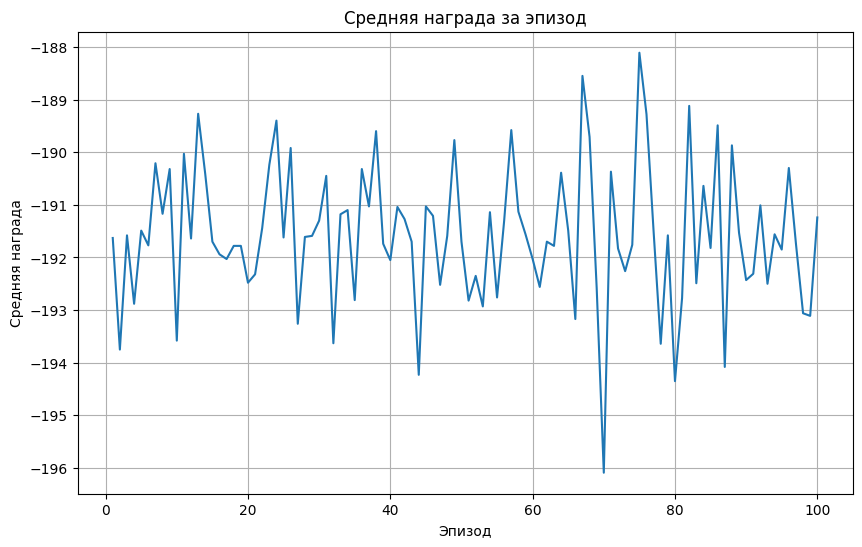

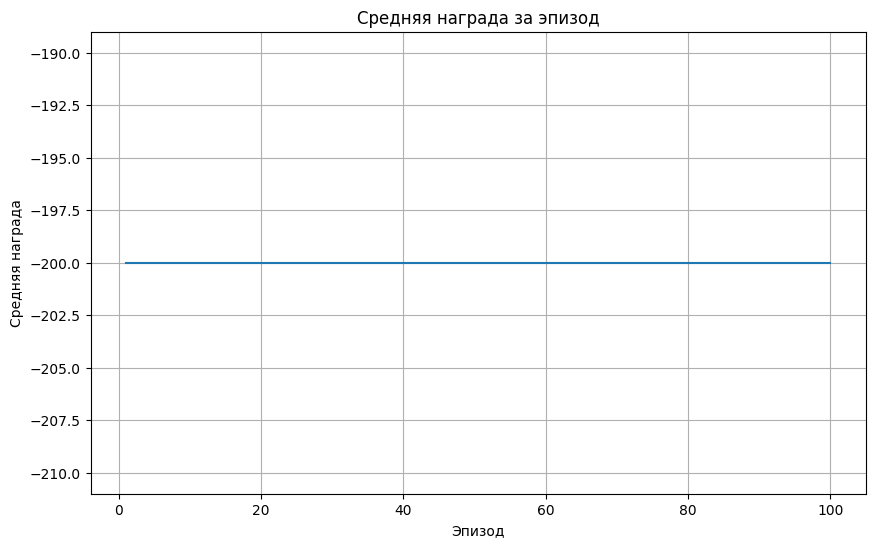

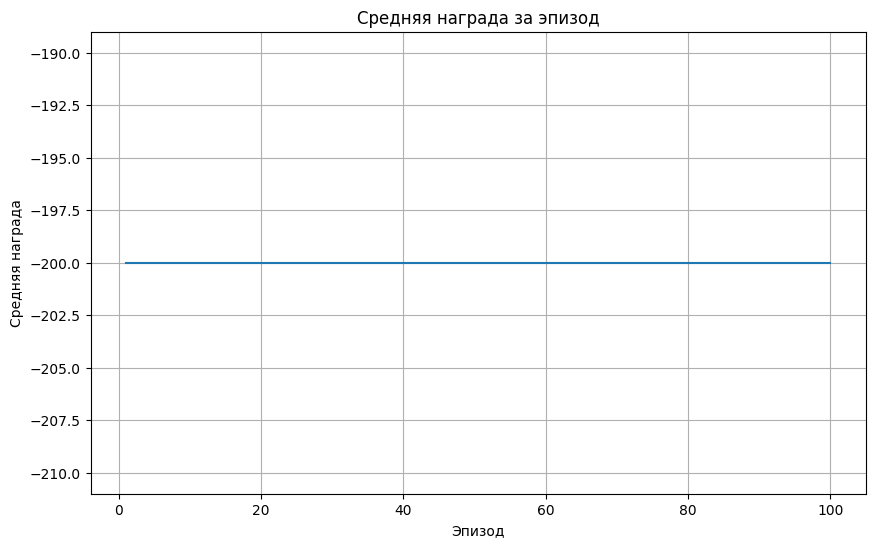

In [22]:
# Визуализация средней награды
def plot_rewards(agent, num_episodes=100, evaluation_episodes=100):
    rewards = []
    for episode in range(1, num_episodes + 1):
        rewards.append(evaluate_agent(agent, evaluation_episodes))

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_episodes + 1), rewards)
    plt.title('Средняя награда за эпизод')
    plt.xlabel('Эпизод')
    plt.ylabel('Средняя награда')
    plt.grid(True)
    plt.show()


# График средней награды для SARSA
plot_rewards(sarsa_agent)

# График средней награды для Q-Learning
plot_rewards(q_learning_agent)

# График средней награды для Double Q-Learning
plot_rewards(double_q_learning_agent)
